## Aggregated Load Model

This notebook contains code for a model that predicts the aggregated load of all 27 heat pumps

In order to keep this notebook clearly readable, some functions are outsourced in utils/

### Imports

In [14]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from livelossplot import PlotLossesKeras

import plotly.graph_objs as go
from utils.data_utils import data_loader
import config

In [8]:
def aggregate_and_convert_data(data, weather_columns):
    """
    Aggregates the data based on the given weather columns, converts timestamps, and sets 'index' as the last column.

    Parameters:
    - data (pd.DataFrame): The raw data with a 'index' column for timestamps.
    - weather_columns (list): List of column names related to weather data.

    Returns:
    - pd.DataFrame: Aggregated data with 'index' as the last column.
    """
    # Convert timestamps to datetime
    data['index'] = pd.to_datetime(data['index'], unit='s')  # Use unit='ms' if timestamps are in milliseconds

    # Set timestamp as index temporarily for aggregation
    data.set_index('index', inplace=True)

    # Define aggregation functions
    aggregations = {'P_TOT': 'sum'}
    for column in weather_columns:
        aggregations[column] = 'first'

    # Aggregate data
    aggregated_data = data.groupby(data.index).agg(aggregations)

    # Convert index to Unix timestamps and add as a column 'index' at the end
    aggregated_data['index'] = aggregated_data.index.astype(int) // 10**9  # Convert to Unix timestamps

    # Reorder columns to move 'index' to the end
    columns_order = [col for col in aggregated_data.columns if col != 'index'] + ['index']
    aggregated_data = aggregated_data[columns_order]

    return aggregated_data

# Load data
data = data_loader(config.columns_P)

# Define weather columns
weather_columns = [
    'WEATHER_ATMOSPHERIC_PRESSURE_TOTAL',
    'WEATHER_PRECIPITATION_RATE_TOTAL',
    'WEATHER_PROBABILITY_OF_PRECIPITATION_TOTAL',
    'WEATHER_RELATIVE_HUMIDITY_TOTAL', 'WEATHER_SOLAR_IRRADIANCE_GLOBAL',
    'WEATHER_TEMPERATURE_TOTAL', 'WEATHER_WIND_DIRECTION_TOTAL',
    'WEATHER_WIND_SPEED_TOTAL'
]

# Aggregate and convert data
aggregated_data = aggregate_and_convert_data(data, weather_columns)

# Display the result
aggregated_data.head(3)


,P_TOT,WEATHER_ATMOSPHERIC_PRESSURE_TOTAL,WEATHER_PRECIPITATION_RATE_TOTAL,WEATHER_PROBABILITY_OF_PRECIPITATION_TOTAL,WEATHER_RELATIVE_HUMIDITY_TOTAL,WEATHER_SOLAR_IRRADIANCE_GLOBAL,WEATHER_TEMPERATURE_TOTAL,WEATHER_WIND_DIRECTION_TOTAL,WEATHER_WIND_SPEED_TOTAL,index
index,,,,,,,,,,
2018-12-31 23:30:00,33616.58963,1029.500000,0.0,45.0,100.000000,0.0,8.900,250.0,4.200000,1546299000
2018-12-31 23:45:00,33616.58963,1029.425018,0.0,45.0,100.000000,0.0,8.825,250.0,4.275000,1546299900
2019-01-01 00:00:00,27819.41714,1029.300008,0.0,45.0,98.333333,0.0,8.500,250.0,4.366667,1546300800


In [10]:
from utils.utils import create_daily_sequences
data = aggregated_data.copy()

# scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
df_scaled = pd.DataFrame(scaled_data, columns=data.columns)

print("scaled_data.shape: " + str(scaled_data.shape))
X, y = create_daily_sequences(df_scaled, 3, 1, 1)
print("X.shape: " + str(X.shape))
print("y.shape: " + str(y.shape))

scaled_data.shape: (70178, 10)
X.shape: (728, 288, 10)
y.shape: (728, 96, 1)


In [11]:
from sklearn.model_selection import train_test_split

X_train_val = X[0:int(0.5*len(X))]
y_train_val = y[0:int(0.5*len(y))]
X_test = X[int(0.5*len(X)):]
y_test = y[int(0.5*len(X)):]
X_train, X_val, y_train, y_val = train_test_split(
                                        X_train_val, y_train_val, 
                                        test_size=0.2, random_state=42
                                        )
print("Dimensionen X_train: " + str(X_train.shape))
print("Dimensionen X_val: " + str(X_val.shape))
print("Dimensionen X_test: " + str(X_test.shape))
print("Dimensionen y_train: " + str(y_train.shape))
print("Dimensionen y_val: " + str(y_val.shape))
print("Dimensionen y_test: " + str(y_test.shape))

Dimensionen X_train: (291, 288, 10)
Dimensionen X_val: (73, 288, 10)
Dimensionen X_test: (364, 288, 10)
Dimensionen y_train: (291, 96, 1)
Dimensionen y_val: (73, 96, 1)
Dimensionen y_test: (364, 96, 1)


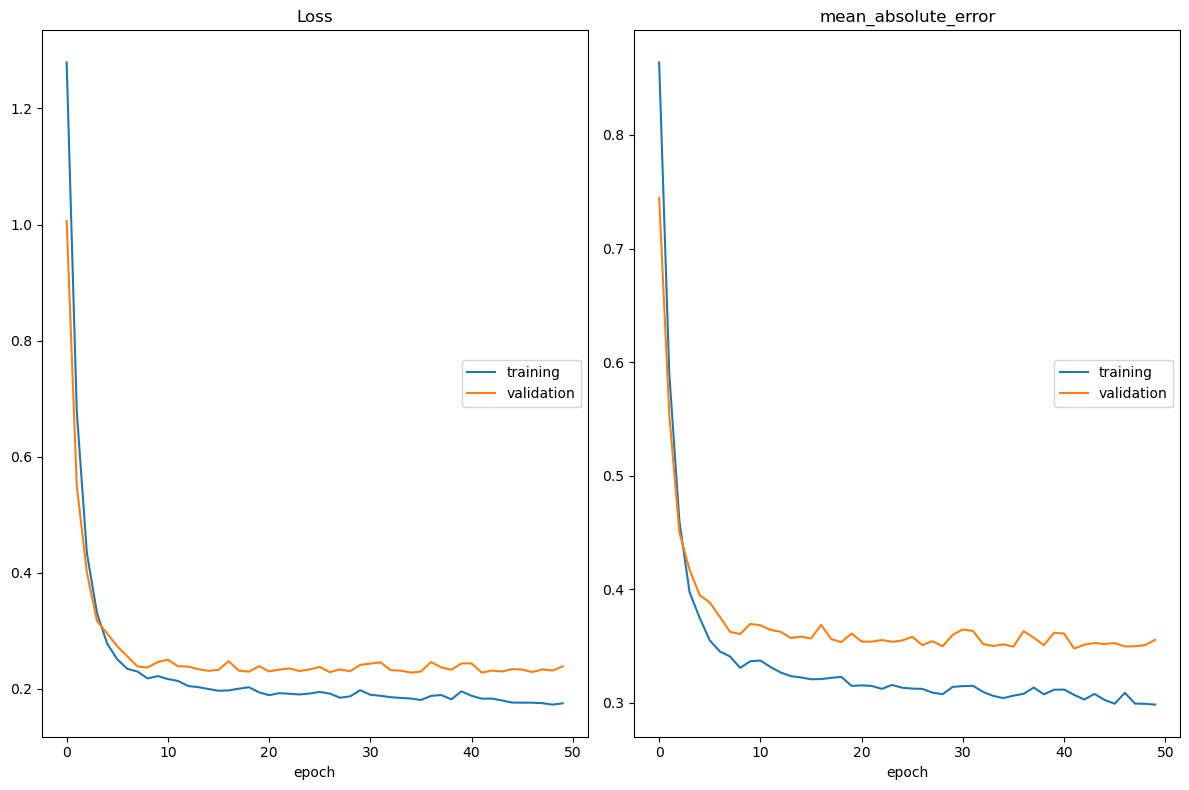

Loss
	training         	 (min:    0.173, max:    1.279, cur:    0.175)
	validation       	 (min:    0.228, max:    1.006, cur:    0.239)
mean_absolute_error
	training         	 (min:    0.298, max:    0.864, cur:    0.298)
	validation       	 (min:    0.348, max:    0.745, cur:    0.355)
10/10 [==============================] - 2s 221ms/step - loss: 0.1752 - mean_absolute_error: 0.2984 - val_loss: 0.2389 - val_mean_absolute_error: 0.3554
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......gru
.........cell
............vars
...............0
...............1
...............2
.........vars
......gru_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars


In [15]:
units_0, units_1 = 64, 128
dropout_0, dropout_1 = 0.1, 0.1
batch_size = 32
units_output = 96
epochs=50

model = Sequential()
# Input Layer
model.add(GRU(units=units_0, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout_0)) 
# Hidden Layers
model.add(GRU(units=units_1,return_sequences=False))
model.add(Dropout(dropout_1))
# Output Layer
model.add(Dense(units_output, activation='linear'))

# Compile
model.compile(optimizer="adam", loss='mean_squared_error', metrics=['mean_absolute_error'])

# Trainieren des Modells
history = model.fit(
    X_train, y_train,                   
    epochs=epochs,                          
    batch_size=batch_size,                      
                                       
    validation_data=(X_val, y_val),     
    callbacks=[PlotLossesKeras()],
    use_multiprocessing=True,          
    workers=4,                          
    verbose=1,                          
)

with open('data/models/history/P_simple_agg_history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [17]:
# Erstellung des Plotly-Diagramms
fig = go.Figure()

# Hinzufügen des Trainingsverlustes
fig.add_trace(go.Scatter(
    y=history.history['loss'], 
    mode='lines', 
    name='Trainingsverlust'
))

# Hinzufügen des Validierungsverlustes
fig.add_trace(go.Scatter(
    y=history.history['val_loss'], 
    mode='lines', 
    name='Validierungsverlust'
))

fig.update_layout(
    title='Trainings- und Validierungsverlust {}'.format("aggregierte Last"),
    title_x=0.5,
    legend_x=0.8,
    xaxis_title='Epochen',
    yaxis_title='Verlust',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()

In [19]:
from utils.utils import inverse_transform

# Vorhersagen auf den Testdaten machen
y_predicted = model.predict(X_test)
print("Shape predicted_test {}".format(y_predicted.shape))
print("Shape y_test {}".format(y_test.shape))

actual_values, predictions, X_test_actual = inverse_transform(y_predicted, y_test, X_test, scaler, aggregated_data.columns, 1, "P_TOT")

12/12 [==============================] - 1s 47ms/step
Shape predicted_test (364, 96)
Shape y_test (364, 96, 1)


In [20]:
from utils.utils import get_monthly_metrics

monthly_metrics = get_monthly_metrics(X_test_actual, actual_values, predictions)
monthly_metrics

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}


,Januar,Februar,März,April,Mai,Juni,Juli,August,September,Oktober,November,Dezember,Mittelwert
RMSE,6409.73,6306.41,5498.85,3767.81,3586.44,2951.38,3144.42,2882.69,3746.40,5128.94,5461.86,5493.37,4531.53
MAE,5181.17,5086.37,4487.76,3132.09,3024.88,2479.29,2620.22,2358.77,3145.46,4179.22,4439.62,4396.60,3710.95
MAPE,0.23,0.26,0.30,0.49,0.67,0.87,1.07,1.26,1.33,1.25,1.17,1.10,0.83
nRMSE,15.57,16.29,16.94,18.61,20.74,24.02,27.32,29.53,30.70,29.90,28.97,28.01,23.88


In [26]:
from utils.plot_utils import plot_results

plot_results(actual_values, predictions, X_test_actual, 1, traces={"actual":True, "prediction":True, "smoothing":False, "boosting":False},  legend_x=0.32)

RMSE Original vs. Vorhersage: 5725.40
